In [190]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-bright')

In [191]:
def generate_microstates(n):
    states = [list(format(i, f'0{n}b')) for i in range(2**n)]
    return {tuple(map(int, state)) for state in states}
    #return states

In [192]:
# constants 
S_REF = 1.2
T_REF = 298
SIGMA = 0.001
R = 8.314
LO_THRESH = 2   # lower threshold for number of ordered residues to consider as start of folding path. 


def get_s_temp(temp, s_ref=S_REF):
    # get the s value at the given temperature
    s = math.pow(s_ref, (T_REF/temp))
    return s

def calc_penalty(state, s_temp):
    # calc penalty for the given state as sigma*s^nhelix
    state = [1 if int(i) == 1 else 0 for i in state]
    nhelix = np.sum(state)
    return SIGMA * math.pow(s_temp, nhelix)

def compute_free_energy(state, temp):
    # calc free energy of the state
    s_temp = get_s_temp(temp)
    penalty = calc_penalty(state, s_temp)
    energy = -R*temp*math.log(penalty)
    return energy

In [193]:
def get_sw(dE, T=298):
    # calculates the statistical weight 
    R = 8.314
    w = np.exp(-dE/(R*T))
    return w

In [194]:
from Levenshtein import distance 

# this code block can be ignored for now. 
def get_key(state):
    return ''.join([str(i) for i in state])

def generate_ssa_seqs(nres):
    seqs = []

    for start in range(nres):
        for end in range(nres):
            seq = [0]*nres
            if start <= end:
                seq[start:end+1] = [1]*(end-start+1)
            seq = ''.join([str(i) for i in seq])
            seqs.append(seq)
    return list(set(seqs))

def get_distance(seq1, seq2):
    dist = distance(seq1, seq2)
    return dist

def neighbours(seq, total_seqs):
    nlist = []
    for i in total_seqs:
        if get_distance(seq, i) == 1:
            temp = list(i)
            temp = [int(i) for i in temp]
            nlist.append(temp)
    return nlist

def generate_neighbour_list(total_seqs):
    neighbour_dict = {}
    for i in total_seqs:
        neighbour_dict[i] = neighbours(i, total_seqs)
    return neighbour_dict

In [195]:
def get_folding_route(path):
    # finds the folding path using the generated path
    reverse_path = path[::-1]
    folding_path = []
    for i in reverse_path:
        helix = [int(j) for j in range(len(i)) if i[j] == '1']
        if len(helix) < LO_THRESH:
            break
        else:
            folding_path.append(i)

    return folding_path[::-1]

In [196]:
def check_if_allowed(curr_state, residue):
    # # check if residue is helix or coil
    # # if helix then check if it is on the edge of helix
    # # if yes then return true
    # # else return false

    # # if coil then check if helix already exists
    # # if yes then return false
    # # if no then return true
        
    helix = [int(i) for i in range(len(curr_state)) if curr_state[i] == '1']
    # print(helix)
    if residue in helix:
        if residue == helix[0] or residue == helix[-1]:
            return True
        else:
            return False
    else:
        if len(helix) == 0:
            return True
        else:
            if residue+1 == helix[0] or residue-1 == helix[-1]:
                return True
            else:
                return False



In [197]:
def monte_carlo_folding(n, steps=10000, temp = 298):
    microstates = generate_ssa_seqs(n)
    state_energy = {state: compute_free_energy(state, temp) for state in microstates}
    # display(state_energy)
    start_state = ''.join(['0']*n)
    # print('start state', start_state)
    # print(microstates)
    macrostates = []
    path = []
    current_state = start_state
    next_state = current_state
    for i in range(steps):
        path.append(current_state)
        temp_lst = [int(i) for i in current_state]
        nhelix = sum(temp_lst)
        macrostates.append(nhelix)
        if current_state != '1'*n:
            # pick random neighbour
            # print(current_state)
            residue = random.randint(0, n-1)
            # print(residue)
            # check if after modifying residue in state, the state is in accessibles

                #chosen_state = min(neighbors, key=lambda s: state_energy[s])
            if check_if_allowed(current_state, residue):
                next_state = current_state[:residue] + str(1-int(current_state[residue])) + current_state[residue+1:]
                # print('next state', next_state)
            else:
                next_state = current_state
                # path.append(current_state)
                continue
        
            dE = state_energy[next_state] - state_energy[current_state] # compute energy difference
            temp_lst = [int(i) for i in current_state]
            nhelix = sum(temp_lst)
            # print('delta', dE)  
            w = get_sw(dE, temp)
            
            # if w > 1: move to next state
            # if w <= 1: get random number r between 0 and 1 and if w >= r, move to next state
            # else stay in current state

            if w > 1:
                current_state = next_state
            else:
                r = random.random()
                if w >= r:
                    current_state = next_state
                else:
                    pass
            # path.append(current_state)
            
        else:
            print(len(path), i)
            break
        # print(path)
        if i % 10000 == 0:
            print(f'{i} steps completed')

    return path, macrostates

In [198]:
path, macrostates = monte_carlo_folding(15)
print(f"Estimated number of microscopic folding routes: {len(path)}")

0 steps completed
451 450
Estimated number of microscopic folding routes: 451


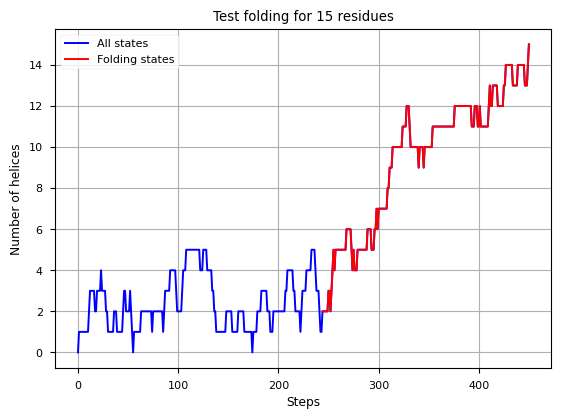

In [199]:
# plotting the folding path
folding_path = get_folding_route(path)
folding_macrostates = []
for state in folding_path:
    temp_lst = [int(i) for i in state]
    nhelix = sum(temp_lst)
    folding_macrostates.append(nhelix)


plt.plot(macrostates, color='blue')
plt.plot(range(len(macrostates)-len(folding_macrostates), len(macrostates)), folding_macrostates, color='red')
plt.legend(['All states', 'Folding states'])
plt.xlabel('Steps')
plt.ylabel('Number of helices') 
plt.title('Test folding for 15 residues')
plt.grid()
plt.show()

In [200]:
from collections import Counter
print(Counter(folding_macrostates))

Counter({11: 40, 12: 33, 10: 30, 5: 27, 13: 16, 14: 15, 6: 12, 7: 10, 2: 7, 4: 6, 9: 5, 3: 3, 8: 2, 15: 1})
